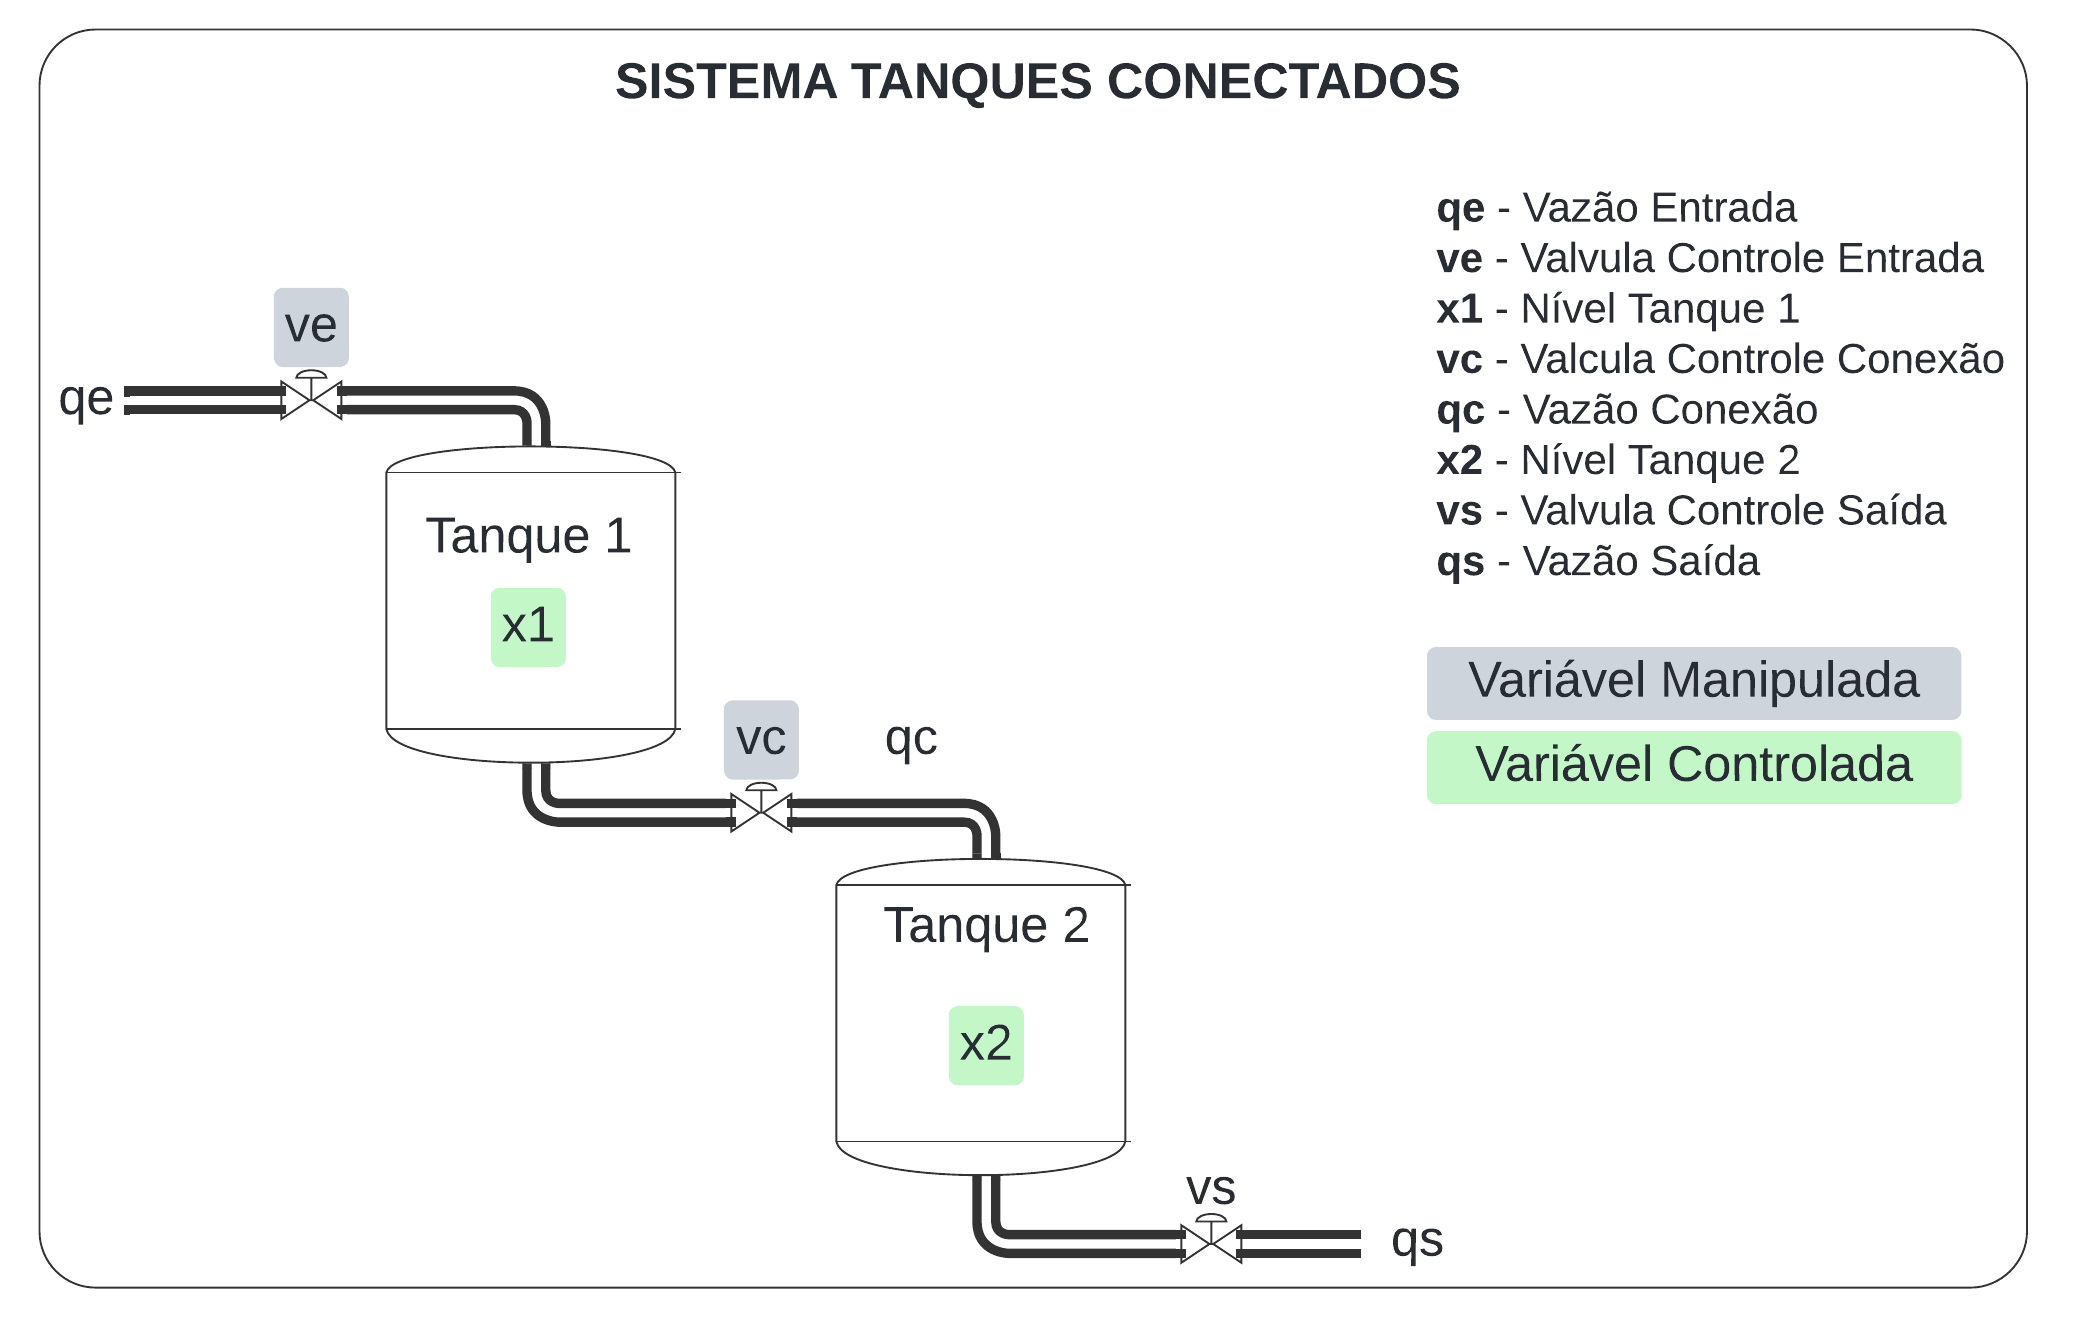

In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
SEED = 1
os.environ['PYTHONHASHSEED']=str(SEED)

import matplotlib.pyplot as plt
from matplotlib import patches
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from pandas import DataFrame, read_csv
import math
from keras import layers
from keras.layers import Input, LSTM, Dense, Reshape, Dropout, Lambda
from keras.models import Model, Sequential, load_model
from functools import partial
import joblib
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(SEED)
   tf.random.set_seed(SEED)
   np.random.seed(SEED)
   random.seed(SEED)

reset_random_seeds()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [2]:
def plot_sim_history(sim_history_x1, sim_history_x2):
  plt.figure(figsize=(16, 10))  # Define o tamanho do gráfico

  plt.subplot(3, 1, 1)
  plt.plot(sim_history_x1['x'], label='x1')
  plt.plot(sim_history_x1['ref'], label='ref1', linestyle=':')
  plt.plot(sim_history_x2['x'], label='x2')
  plt.plot(sim_history_x2['ref'], label='ref2', linestyle=':')
  plt.xlabel("Steps/Time(s)")
  plt.ylabel("Level(m)")
  plt.title('Gráfico de Controle Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.subplot(3, 1, 2)
  plt.plot(sim_history_x1['qe'], label='qe')
  plt.plot(sim_history_x1['qs'], label='qs')
  plt.ylabel("(m^3/s)")
  plt.title('Gráfico de Sinal Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout


  plt.subplot(3, 1, 3)
  plt.plot(sim_history_x1['erro'], label='erro')
  plt.ylabel("erro (m)")
  plt.title('Gráfico de Erro Aprendizado Por Reforço')
  plt.legend()
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  plt.show()

In [3]:
def plotting(history):
    fig = plt.figure(figsize=(16, 4))
    plt.semilogy(history.history['loss'], color = "red")
    plt.semilogy(history.history['val_loss'], color = "blue")
    red_patch = patches.Patch(color='red', label='Training')
    blue_patch = patches.Patch(color='blue', label='Validation')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    fig.savefig(f'{plot_name}-train-history.png', format='png', dpi=600)

In [4]:
# Criando o gráfico
def plot_sim_degree(sim_degree):
  fig1 = plt.figure(1, figsize=(16, 4))  # Define o tamanho do gráfico

  #fig, ax = plt.subplots()

  # Plot da variável de controle

  plt.scatter(sim_degree["l"], sim_degree["x1"]   , label='X1'            , alpha=0.5)
  plt.scatter(sim_degree["l"], sim_degree["NN_x1"], label='X1 Rede Neural', alpha=1.0, marker='+')

  plt.xticks(np.arange(0, 13, 1))
  plt.yticks(np.arange(0, 13, 1))

  # Adicionando rótulos aos eixos e título
  plt.xlabel('Nível Inicial')
  plt.ylabel('Nível Final')
  plt.title('Comportamento Processo x Modelo ao Degrau - x1')

  # Adicionando legenda
  plt.legend()

  # Exibindo o gráfico
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout


  fig2 = plt.figure(2, figsize=(16, 4))  # Define o tamanho do gráfico

  #fig, ax = plt.subplots()

  # Plot da variável de controle
  plt.scatter(sim_degree["l"], sim_degree["x2"]   , label='X2'            , alpha=0.5)
  plt.scatter(sim_degree["l"], sim_degree["NN_x2"], label='X2 Rede Neural', alpha=1.0, marker='+')

  plt.xticks(np.arange(0, 13, 1))
  plt.yticks(np.arange(0, 13, 1))

  # Adicionando rótulos aos eixos e título
  plt.xlabel('Nível Inicial')
  plt.ylabel('Nível Final')
  plt.title('Comportamento Processo x Modelo ao Degrau - x2')

  # Adicionando legenda
  plt.legend()

  # Exibindo o gráfico
  plt.grid(True)  # Adiciona uma grade ao gráfico
  plt.tight_layout()  # Ajusta o layout

  fig1.savefig(f'{plot_name}-degree-1.png', format='png', dpi=600)
  fig2.savefig(f'{plot_name}-degree-2.png', format='png', dpi=600)

  plt.show()

Processo que representa um o nível de um tanque com um registro

In [5]:
import math

# Process Const
area = 16
max_level = 12
def tank_xdot(x, qe, valve=100, valve_k = 1):
  if x >= 0:
    qs = valve_k * (valve / 100) * math.sqrt(x)
  else:
    qs = 0
  xd = (qe - qs) / area
  return xd, qs

def tank_rk(x0, qe, valve=100, valve_k = 1, t=0.2):
  a=x0
  b=qe
  c=valve
  #call 1
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  savex0 = x0;
  phi = xd;
  x0 = savex0 + 0.5 * t * xd;

  #call two
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + 0.5 * t * xd;

  #call three
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  phi = phi + 2 * xd;
  x0 = savex0 + t * xd;

  #call four
  xd, qs = tank_xdot(x0, qe, valve, valve_k);
  x = savex0 + (phi + xd) * t / 6;

  if x < 0:
    x = 0

  if x > max_level:
    x = max_level

  if np.isnan(x):
    x = 0

  if np.isnan(qs):
    qs = 0

  return x, qs;

In [6]:
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.width', 1000)

In [7]:
# Parametros Globais
np.random.seed(56)
k1 = 2
k2 = 1
ts = 0.3
model_horizon = 5
pmc_horizon = 5
num_data = 10000
data_name = f"data-{num_data}_hor-{model_horizon}_ts-{ts}"

plot_name = f'pmc_nn-2tanques_{data_name}'
path = f'/content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/pmc_nn-2tanques_{data_name}'
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)
print(f'O diretório  é: {os.getcwd()}')
print(f'O plot_name  é: {plot_name}')

O diretório  é: /content/drive/MyDrive/Colab Notebooks/Mestrado/Final/Data/pmc_nn-2tanques_data-10000_hor-5_ts-0.3
O plot_name  é: pmc_nn-2tanques_data-10000_hor-5_ts-0.3


In [8]:
scaler_x_train = joblib.load(f"datatrain_scaler-x_{data_name}.pkl")
x_train = np.load(f"datatrain-x_{data_name}.npy")
y_train = np.load(f"datatrain-y_{data_name}.npy")

Modelo de Rede Neural

In [9]:
model = Sequential()
model.add(Lambda(lambda x: x[:]))
model.add(Dense(32, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(64, activation=partial(tf.nn.leaky_relu, alpha=0.5)))
model.add(Dense(2, kernel_initializer=tf.initializers.zeros))

In [10]:
lr=0.001
optimizer = tf.optimizers.Adam(learning_rate=lr)
loss=tf.losses.MeanSquaredError()
metrics=[tf.metrics.MeanSquaredError()]
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitora a métrica de validação
    patience=20,  # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaura os pesos do modelo à melhor época
)

In [12]:
num_epochs=200
num_batch_size=10
history = model.fit(
            x = x_train,
            y = y_train,
            batch_size = num_batch_size,
            epochs = num_epochs,
            verbose = 1,
            callbacks=[early_stopping],
            validation_split = 0.2
          )
history

Epoch 1/200
800/800 [==============================] - 7s 7ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 2/200
800/800 [==============================] - 5s 7ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 3/200
800/800 [==============================] - 5s 6ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 4/200
800/800 [==============================] - 4s 5ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 5/200
800/800 [==============================] - 3s 4ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 6/200
800/800 [==============================] - 2s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 7/200
800/800 [=

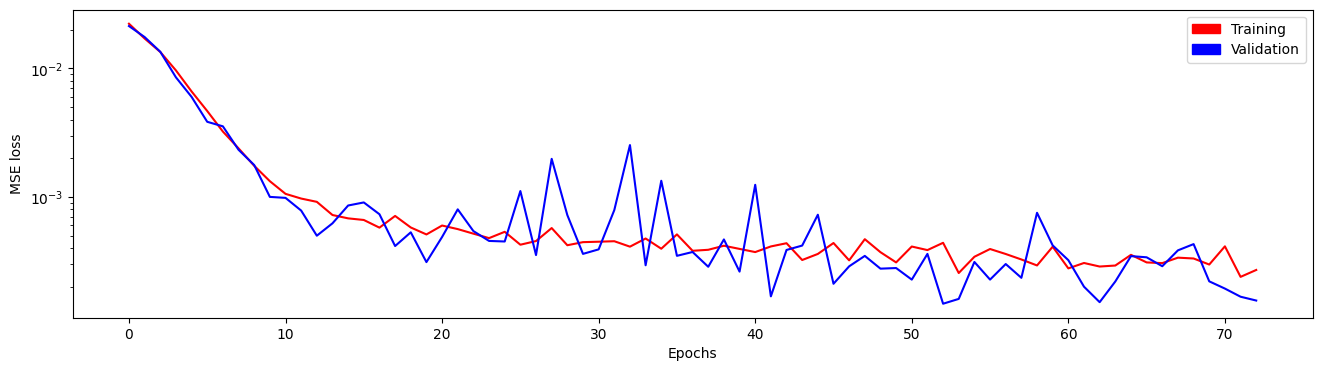

In [13]:
plotting(history)

Simulação Degrau Unitário para verificar se a rede neural tem comportamento semelhante ao processo.

In [14]:
sim_degree_columns = ["l","qe", "qc", "qs", "x1", "x2", "NN_x1", "NN_x2"]
sim_degree = []

qe = 2.0;
vc = 100
vs = 100
t = 0

for l in range(13):
  t+=1

  x1 = l;
  x2 = l;
  NN_x1 = l;
  NN_x2 = l;

  for _ in range(int(pmc_horizon/model_horizon)):
    NN_in = np.array([[NN_x1, qe, vc, NN_x2, vs]])
    NN_in = scaler_x_train.transform(NN_in)
    NN_pred = model.predict(NN_in, verbose = None);

    NN_x1 += NN_pred[0][0]
    NN_x2 += NN_pred[0][1]

  for _ in range(pmc_horizon):
    x1, qc = tank_rk(x1, qe, vc, k1, ts)
    x2, qs = tank_rk(x2, qc, vs, k2, ts)

  sim_degree.append([l, qe, qc, qs, x1, x2, NN_x1, NN_x2])
sim_degree = pd.DataFrame(data = sim_degree, columns = sim_degree_columns)
sim_degree.to_csv('sim_degree.csv', index=False)
sim_degree

,l,qe,qc,qs,x1,x2,NN_x1,NN_x2
0,0,2.0,0.746171,0.205284,0.139192,0.042142,0.070822,0.026816
1,1,2.0,2.000000,1.044805,1.000000,1.091618,1.002671,1.067349
2,2,2.0,2.774793,1.458572,1.924869,2.127432,1.927869,2.114357
3,3,2.0,3.386099,1.776473,2.866416,3.155857,2.851504,3.163135
4,4,2.0,3.907357,2.044542,3.816860,4.180152,3.801311,4.191446
5,5,2.0,4.369469,2.280728,4.773065,5.201718,4.762024,5.209755
6,6,2.0,4.788901,2.494255,5.733394,6.221308,5.722630,6.232193
7,7,2.0,5.175660,2.690610,6.696864,7.239381,6.683731,7.255175
8,8,2.0,5.536363,2.873368,7.662829,8.256244,7.659797,8.262438
9,9,2.0,5.875658,3.045014,8.630839,9.272111,8.635405,9.277824


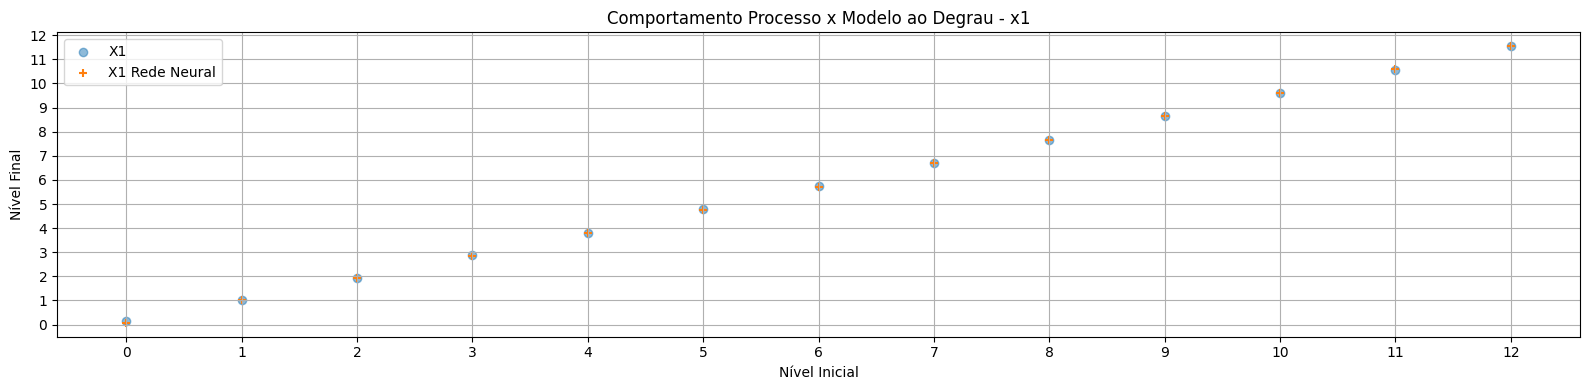

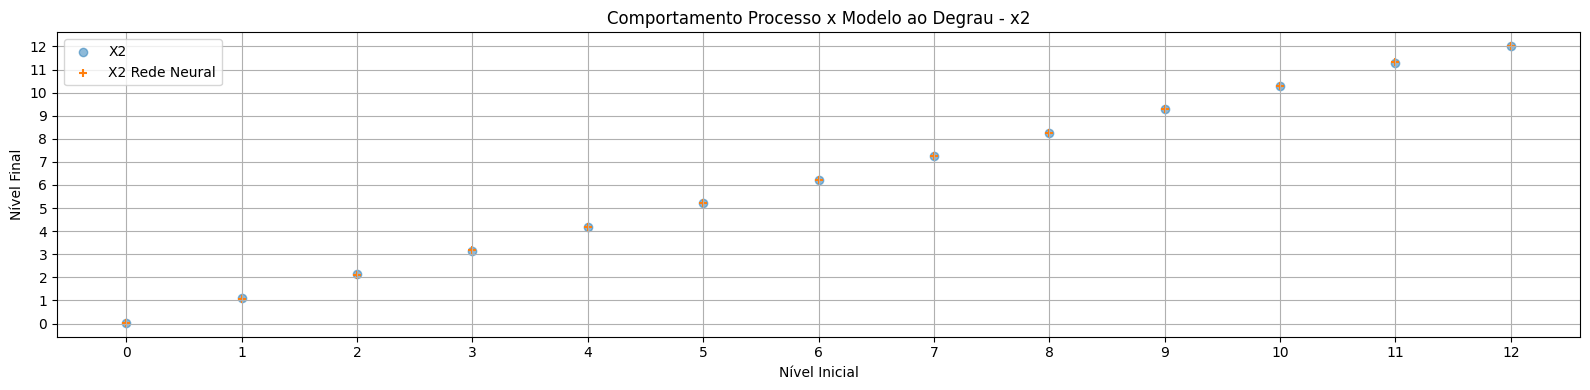

In [15]:
 plot_sim_degree(sim_degree)

In [16]:
model.save_weights(f"model-weights_{data_name}/model")